In [24]:
from keras.models import Model
from keras.layers.core import Dropout, Activation, Reshape
from keras.layers.convolutional import Convolution2D, Deconvolution2D, AtrousConvolution2D, UpSampling2D
from keras.layers.pooling import AveragePooling2D
from keras.layers import Input, Concatenate
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.engine.topology import get_source_inputs
from keras.applications.imagenet_utils import _obtain_input_shape
import keras.backend as K

In [65]:
def DenseNetFCN(input_shape, batch_norm=True, nb_dense_block=5, growth_rate=16, nb_layers_per_block=4,
                reduction=0.0, dropout_rate=0.0, weight_decay=1E-4, init_conv_filters=48, classes=1):
    """Instantiate the DenseNet FCN architecture.
        Note that when using TensorFlow,
        for best performance you should set
        `image_dim_ordering="tf"` in your Keras config
        at ~/.keras/keras.json.
        # Arguments
            nb_dense_block: number of dense blocks to add to end (generally = 3)
            growth_rate: number of filters to add per dense block
            nb_layers_per_block: number of layers in each dense block.
                Can be a positive integer or a list.
                If positive integer, a set number of layers per dense block.
                If list, nb_layer is used as provided. Note that list size must
                be (nb_dense_block + 1)
            reduction: reduction factor of transition blocks.
                Note : reduction value is inverted to compute compression.
            dropout_rate: dropout rate
            weight_decay: weight decay factor
            init_conv_filters: number of layers in the initial convolution layer
            input_shape: optional shape tuple, only to be specified
                It should have exactly 3 inputs channels,
                and width and height should be no smaller than 8.
                E.g. `(200, 200, 3)` would be one valid value.
            classes: optional number of classes to classify images
                into, only to be specified if `include_top` is True, and
                if no `weights` argument is specified.
            activation: Type of activation at the top layer. Can be one of 'softmax' or 'sigmoid'.
                Note that if sigmoid is used, classes must be 1.
        # Returns
            A Keras model instance.
    """
    if type(nb_layers_per_block) is not list and nb_dense_block < 1:
        raise ValueError('Number of dense layers per block must be greater than 1. Argument '
                         'value was %d.' % (nb_layers_per_block))

    # Determine proper input shape
    min_size = 2 ** nb_dense_block

    if input_shape is not None:
        if ((input_shape[0] is not None and input_shape[0] < min_size) or
                (input_shape[1] is not None and input_shape[1] < min_size)):
            raise ValueError('Input size must be at least ' +
                             str(min_size) + 'x' + str(min_size) + ', got '
                                                                   '`input_shape=' + str(input_shape) + '`')
    else:
        input_shape = (None, None, classes)


    img_input = Input(shape=input_shape)
    x = __create_fcn_dense_net(classes, img_input, batch_norm, nb_dense_block,
                               growth_rate, reduction, dropout_rate, weight_decay,
                               nb_layers_per_block,init_conv_filters, input_shape)

    # Create model.
    model = Model(img_input, x, name='fcn-densenet')

    return model


def __conv_block(ip, nb_filter, batch_norm=True, bottleneck=False, dropout_rate=None, weight_decay=1E-4):
    ''' Apply BatchNorm, Relu, 3x3 Conv2D, optional bottleneck block and dropout
    Args:
        ip: Input keras tensor
        nb_filter: number of filters
        bottleneck: add bottleneck block
        dropout_rate: dropout rate
        weight_decay: weight decay factor
    Returns: keras tensor with batch_norm, relu and convolution2d added (optional bottleneck)
    '''

    concat_axis = -1

    if batch_norm:
        x = BatchNormalization(axis=concat_axis, gamma_regularizer=l2(weight_decay),
                                beta_regularizer=l2(weight_decay))(ip)
    else:
        x = ip
        
    x = Activation('relu')(x)

    if bottleneck:
        inter_channel = nb_filter * 4  # Obtained from https://github.com/liuzhuang13/DenseNet/blob/master/densenet.lua

        x = Convolution2D(inter_channel, 1, 1, init='he_uniform', border_mode='same', bias=False,
                          W_regularizer=l2(weight_decay))(x)

        if dropout_rate:
            x = Dropout(dropout_rate)(x)

        if batch_norm:
            x = BatchNormalization(axis=concat_axis, gamma_regularizer=l2(weight_decay),
                                   beta_regularizer=l2(weight_decay))(x)
        x = Activation('relu')(x)

    x = Convolution2D(nb_filter, (3, 3), padding="same", use_bias=False,
                      kernel_initializer="he_uniform",
                      kernel_regularizer=l2(weight_decay))(x)
    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    return x


def __transition_block(ip, nb_filter, batch_norm=True, compression=1.0, dropout_rate=None, weight_decay=1E-4):
    ''' Apply BatchNorm, Relu 1x1, Conv2D, optional compression, dropout and Maxpooling2D
    Args:
        ip: keras tensor
        nb_filter: number of filters
        compression: calculated as 1 - reduction. Reduces the number of feature maps
                    in the transition block.
        dropout_rate: dropout rate
        weight_decay: weight decay factor
    Returns: keras tensor, after applying batch_norm, relu-conv, dropout, maxpool
    '''

    concat_axis = -1

    if batch_norm:
        x = BatchNormalization(axis=concat_axis, gamma_regularizer=l2(weight_decay),
                               beta_regularizer=l2(weight_decay))(ip)
    else:
        x = ip
        
    x = Activation('relu')(x)
    x = Convolution2D(int(nb_filter * compression), (1, 1), padding="same", use_bias=False,
                      kernel_initializer="he_uniform",
                      kernel_regularizer=l2(weight_decay))(x)
    if dropout_rate:
        x = Dropout(dropout_rate)(x)
    x = AveragePooling2D((2, 2), strides=(2, 2))(x)

    return x


def __dense_block(x, nb_layers, nb_filter, growth_rate, batch_norm=True, bottleneck=False, dropout_rate=None, weight_decay=1E-4,
                  grow_nb_filters=True, return_concat_list=False):
    ''' Build a dense_block where the output of each conv_block is fed to subsequent ones
    Args:
        x: keras tensor
        nb_layers: the number of layers of conv_block to append to the model.
        nb_filter: number of filters
        growth_rate: growth rate
        bottleneck: bottleneck block
        dropout_rate: dropout rate
        weight_decay: weight decay factor
        grow_nb_filters: flag to decide to allow number of filters to grow
        return_concat_list: return the list of feature maps along with the actual output
    Returns: keras tensor with nb_layers of conv_block appended
    '''

    concat_axis = -1

    x_list = [x]

    for i in range(nb_layers):
        x = __conv_block(x, growth_rate, batch_norm, bottleneck, dropout_rate, weight_decay)
        x_list.append(x)

        x = Concatenate(axis=concat_axis)(x_list)

        if grow_nb_filters:
            nb_filter += growth_rate

    if return_concat_list:
        return x, nb_filter, x_list
    else:
        return x, nb_filter


def __transition_up_block(ip):
    ''' SubpixelConvolutional Upscaling (factor = 2)
    Args:
        ip: keras tensor
    Returns: keras tensor, after applying upsampling operation.
    '''
    x = UpSampling2D()(ip)
    return x


def __create_fcn_dense_net(nb_classes, img_input, batch_norm=True, nb_dense_block=5, growth_rate=12,
                           reduction=0.0, dropout_rate=None, weight_decay=1E-4,
                           nb_layers_per_block=4, init_conv_filters=48,
                           input_shape=None):
    ''' Build the DenseNet model
    Args:
        nb_classes: number of classes
        img_input: tuple of shape (channels, rows, columns) or (rows, columns, channels)
        nb_dense_block: number of dense blocks to add to end (generally = 3)
        growth_rate: number of filters to add per dense block
        reduction: reduction factor of transition blocks. Note : reduction value is inverted to compute compression
        dropout_rate: dropout rate
        weight_decay: weight decay
        nb_layers_per_block: number of layers in each dense block.
            Can be a positive integer or a list.
            If positive integer, a set number of layers per dense block.
            If list, nb_layer is used as provided. Note that list size must
            be (nb_dense_block + 1)
        input_shape: Only used for shape inference in fully convolutional networks.
    Returns: keras tensor with nb_layers of conv_block appended
    '''

    concat_axis = -1
    rows, cols, _ = input_shape

    if reduction != 0.0:
        assert reduction <= 1.0 and reduction > 0.0, "reduction value must lie between 0.0 and 1.0"

    # layers in each dense block
    if type(nb_layers_per_block) is list or type(nb_layers_per_block) is tuple:
        nb_layers = list(nb_layers_per_block)  # Convert tuple to list

        assert len(nb_layers) == (nb_dense_block + 1), "If list, nb_layer is used as provided. " \
                                                       "Note that list size must be (nb_dense_block + 1)"

        bottleneck_nb_layers = nb_layers[-1]
        rev_layers = nb_layers[::-1]
        nb_layers.extend(rev_layers[1:])
    else:
        bottleneck_nb_layers = nb_layers_per_block
        nb_layers = [nb_layers_per_block] * (2 * nb_dense_block + 1)

    # compute compression factor
    compression = 1.0 - reduction

    # Initial convolution
    x = Convolution2D(init_conv_filters, (3, 3), padding="same", use_bias=False, 
                      kernel_initializer="he_uniform",
                      kernel_regularizer=l2(weight_decay),
                      name="initial_conv2D")(img_input)

    nb_filter = init_conv_filters

    skip_list = []

    # Add dense blocks and transition down block
    for block_idx in range(nb_dense_block):
        x, nb_filter = __dense_block(x, nb_layers[block_idx], nb_filter, growth_rate,
                                     batch_norm=batch_norm,
                                     dropout_rate=dropout_rate, weight_decay=weight_decay)

        # Skip connection
        skip_list.append(x)

        # add transition_block
        x = __transition_block(x, nb_filter,
                               batch_norm=batch_norm,
                               compression=compression, dropout_rate=dropout_rate,
                               weight_decay=weight_decay)

        nb_filter = int(nb_filter * compression)  # this is calculated inside transition_down_block

    # The last dense_block does not have a transition_down_block
    # return the concatenated feature maps without the concatenation of the input
    _, nb_filter, concat_list = __dense_block(x, bottleneck_nb_layers, nb_filter, growth_rate,
                                              batch_norm=batch_norm,
                                              dropout_rate=dropout_rate, weight_decay=weight_decay,
                                              return_concat_list=True)

    skip_list = skip_list[::-1]  # reverse the skip list

    # Add dense blocks and transition up block
    for block_idx in range(nb_dense_block):
        n_filters_keep = growth_rate * nb_layers[nb_dense_block + block_idx]

        # upsampling block must upsample only the feature maps (concat_list[1:]),
        # not the concatenation of the input with the feature maps (concat_list[0].
        l = Concatenate(axis=concat_axis)(concat_list[1:])

        t = __transition_up_block(l)

        # concatenate the skip connection with the transition block
        x = Concatenate(axis=concat_axis)([t, skip_list[block_idx]])

        # Dont allow the feature map size to grow in upsampling dense blocks
        _, nb_filter, concat_list = __dense_block(x, nb_layers[nb_dense_block + block_idx + 1], nb_filter=growth_rate,
                                                  growth_rate=growth_rate, batch_norm=batch_norm,
                                                  dropout_rate=dropout_rate,
                                                  weight_decay=weight_decay,
                                                  return_concat_list=True, grow_nb_filters=False)


    x = Convolution2D(nb_classes, (1, 1), padding='same', use_bias=False,
                      kernel_regularizer=l2(weight_decay),
                      activation='linear')(x)

    return x

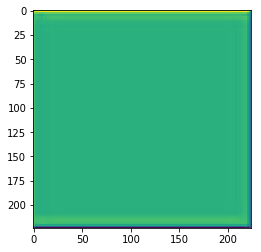

In [66]:
model = DenseNetFCN(input_shape=(None, None, 3), batch_norm=False, nb_dense_block=3, growth_rate=12)

import numpy as np

t = np.ones((1, 224, 224, 3))

p = model.predict(t)

import matplotlib.pyplot as plt
%matplotlib inline

p.shape

plt.imshow(p[0,:,:,0])

In [67]:
p.shape

(1, 224, 224, 1)

In [68]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, None, None, 3)     0         
_________________________________________________________________
initial_conv2D (Conv2D)      (None, None, None, 48)    1296      
_________________________________________________________________
activation_742 (Activation)  (None, None, None, 48)    0         
_________________________________________________________________
conv2d_751 (Conv2D)          (None, None, None, 12)    5184      
_________________________________________________________________
concatenate_567 (Concatenate (None, None, None, 60)    0         
_________________________________________________________________
activation_743 (Activation)  (None, None, None, 60)    0         
_________________________________________________________________
conv2d_752 (Conv2D)          (None, None, None, 12)    6480      
__________